In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns; sns.set()
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from pandas.util import hash_pandas_object

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
#Uncomment next line when u first use nltk and press download when all in selected on the windows of nltk downloads
#nltk.download()

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from collections import Counter

import string
from ast import literal_eval
#progress bar
from tqdm import tqdm, trange
from time import sleep

#To detect language for stemming
# https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes
#from langdetect import detect

## Import data

In [2]:
raw_data = pd.read_csv('data/en.openfoodfacts.org.products.csv', sep = '\t')

C:\Users\Yann Schilling\Anaconda3\envs\ada\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,24,25,26,28,44,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Drop columns not needed, explore missing values, and delete rows with zero or one value present

In [3]:
columns2keep = ['energy_100g','sugars_100g','saturated-fat_100g','fat_100g','sodium_100g',
    'fruits-vegetables-nuts_100g','fiber_100g','proteins_100g','nutrition-score-uk_100g',
    'nutrition_grade_fr','main_category_en','packaging','categories','labels_en',
    'pnns_groups_1','pnns_groups_2','product_name','ingredients_text']

In [4]:
data = raw_data[columns2keep]

In [5]:
data = data.replace("unknown",np.nan)

In [6]:
data = data.loc[(~data.isnull()).sum(axis=1)>1]

# FOOD CATEGORIES

In our first step, we aim to categorize products according to their Food Category. The PNNS ("Programme national nutrition santé" in French) aims at categorizing food in several major classes: Dairies, Composite, Fish Meat Eggs, Beverages, Fat Sauces, Fruits Vegetables, Starchy, and Snacks.

The PNNS categories were established by a variety of health professionals as part of the French National Nutrition and Health Program. In part, it aimed at dividing food products in well designed categories to have a frame of reference for the analysis of a population's nutrition and the advertisement of health plans. 

### From pnns_groups_1 column

We map the given pnns categories to our 8 major ones

In [10]:
data["pnns_groups_1"].value_counts()

Sugary snacks              60406
Milk and dairy products    45218
Fish Meat Eggs             44342
Cereals and potatoes       35620
Beverages                  29740
Fat and sauces             28933
Composite foods            26598
Fruits and vegetables      25538
Salty snacks               20460
sugary-snacks               3600
fruits-and-vegetables       2995
cereals-and-potatoes          46
salty-snacks                   5
Name: pnns_groups_1, dtype: int64

In [11]:
# dictionnary to normalize category names into PNNS category
pnns1_category = {
 'Sugary snacks' : 'Snacks', 
 'Milk and dairy products' : 'Dairies',
 'Cereals and potatoes' : 'Starchy', 
 'Fish Meat Eggs' : 'Fish Meat Eggs',
 'Beverages' : 'Beverages',
 'Fat and sauces' : 'Fat Sauces',
 'Fruits and vegetables' : 'Fruits Vegetables',
 'Salty snacks' : 'Snacks',
 'fruits-and-vegetables' : 'Fruits Vegetables',
 'sugary-snacks' : 'Snacks',
 'cereals-and-potatoes' : 'Starchy',
 'salty-snacks' : 'Snacks'
}
data.loc[:,'food_category'] = data['pnns_groups_1'].map(pnns1_category)

In [12]:
# New pnns categories
data["food_category"].value_counts()

Snacks               84471
Dairies              45218
Fish Meat Eggs       44342
Starchy              35666
Beverages            29740
Fat Sauces           28933
Fruits Vegetables    28533
Name: food_category, dtype: int64

### From pnns_groups_2 column

We notice that several products haven't been categorized but have a non missing value in pnns_groups_2

In [13]:
# Values of pnns_groups_2 which haven't been classified in food_category
data.loc[data.food_category.isnull()]["pnns_groups_2"].value_counts()

One-dish meals            21513
Alcoholic beverages       10622
Pizza pies and quiche      3004
Sandwiches                 2081
Pizza pies and quiches      406
Name: pnns_groups_2, dtype: int64

Here, we make the decision to not classify Composite food as it doesn't pertain to a particular category. Also, creating a Composite category doesn't make sense for our final analysis.

In [14]:
data.loc[(data.food_category.isnull())&(data.pnns_groups_2 == "Alcoholic beverages"),"food_category"] = "Beverages"

In [15]:
data["food_category"].value_counts()

Snacks               84471
Dairies              45218
Fish Meat Eggs       44342
Beverages            40362
Starchy              35666
Fat Sauces           28933
Fruits Vegetables    28533
Name: food_category, dtype: int64

### From main_category_en column

We complete our categorization with the help of the 'main_category_en' column

In [16]:
data.loc[data.food_category.isnull()]["main_category_en"].value_counts().head(30)

Meals                              17536
Beverages                           9798
Plant-based foods and beverages     7147
Groceries                           6416
Snacks                              3897
Frozen foods                        3130
Dietary supplements                 2393
Sandwiches                          1843
Dairies                             1606
Canned foods                        1598
Desserts                            1359
Baby foods                          1279
Sweeteners                          1277
Meats                               1232
Cooking helpers                      749
Crêpes and galettes                  698
Food additives                       619
Non food products                    569
Spreads                              417
Cocoa and chocolate powders          350
Licensed products                    306
Syrups                               287
Chips and fries                      271
Dried products                       249
es:bolleria-indu

In [17]:
# After inspecting the food type for the 30 most frequent values in main_category_en, we create the following dictionary
maincategoryen_category = {
'Beverages' : 'Beverages',
'Snacks' : 'Snacks',
'Dairies' : 'Dairies',
'Desserts' : 'Dairies',
'Crêpes and galettes' : 'Snacks',
'Cocoa and chocolate powders': 'Snacks',
'Syrups':'Fat Sauces',
'Chips and fries': 'Snacks',
'es:bolleria-industrial': 'Snacks',
'fr:bloc-de-foie-gras-de-canard': 'Fish Meat Eggs' ,
'Pizza dough' : 'Starchy',
'Breakfast' : 'Starchy',
'Banana-crisps' : "Snacks",
'Fish eggs' : 'Fish Meat Eggs',
'Terrines' : 'Fish Meat Eggs',
'fr:escalopes' : 'Fish Meat Eggs',
'Salads' : 'Fruits Vegetables',
'fr:pilons-de-poulet' : 'Fish Meat Eggs'
}

data.loc[data.food_category.isnull(),'food_category'] =  data.loc[data.food_category.isnull(),'main_category_en'].map(maincategoryen_category)

In [18]:
sum(data["food_category"].value_counts())/len(data)

0.3485795853717731

**After these steps, we managed to categorize 34% of our date among PNNS groups.**

For the unclassified data, the other columns don't bring any strong evidence for the categorization of the product. For instance, a lot of Dietary Supplements or Non Food Products stay unclassified. Also, the table beneath shows that no column with above 10% completeness for uncategorized data gives us direct information on food categories.

In [19]:
completeness = raw_data.iloc[data[data.food_category.isnull()].index].count().sort_values(ascending=False)/len(data.loc[data.food_category.isnull()])
completeness.loc[completeness>0.1]

code                                       1.000000
states_en                                  1.000000
url                                        1.000000
creator                                    1.000000
created_t                                  1.000000
created_datetime                           1.000000
last_modified_t                            1.000000
last_modified_datetime                     1.000000
pnns_groups_2                              1.000000
states                                     1.000000
states_tags                                1.000000
pnns_groups_1                              0.999355
countries_en                               0.998841
countries_tags                             0.998841
countries                                  0.998841
product_name                               0.994181
energy_100g                                0.939164
proteins_100g                              0.936268
carbohydrates_100g                         0.934108
fat_100g    

In [20]:
classified_data = data.loc[~data.food_category.isnull()]
unclassified_data = data.loc[data.food_category.isnull()]

In [21]:
classified_data.loc[~classified_data.ingredients_text.isnull(),"ingredients_text"].count()/len(classified_data)

0.6170500593945724

42% of the remaining data has a list of ingredients, and 62% of our classified data also has a list of ingredients. We first use word similarities on the words in ingredient_text to associate unclassified products to categories if the similarity is big enough.

### Using Ingredients_text column 

In [22]:
# We clean the list of ingredients by removing punctuation and numbers
def clean_text(df,col):
    caracters2delete = ['%','-',':',',',"  ",'(',')',';','/','_','*','\d+','.','\'','[',']','•','+']
    df.loc[:,col] = df.loc[:,col].str.lower()
    for c in caracters2delete:
        df.loc[:,col] = df.loc[:,col].str.replace(c,' ')

clean_text(classified_data,"ingredients_text")
clean_text(unclassified_data,"ingredients_text")

# We then transform the text to a list of nonStop words
# The dominant language in the ingredients in french
stopWords = stopwords.words('french') + ["kg","g","v","a","b","k","e","mg","and","of","ml","cl"]

classified_data.loc[~classified_data.ingredients_text.isnull(),'ingredients_text'] = \
    classified_data.loc[~classified_data.ingredients_text.isnull(),'ingredients_text'] \
    .apply(lambda x: [word for word in x.split() if word not in stopWords])
    
unclassified_data.loc[~unclassified_data.ingredients_text.isnull(),'ingredients_text'] = \
    unclassified_data.loc[~unclassified_data.ingredients_text.isnull(),'ingredients_text'] \
    .apply(lambda x: [word for word in x.split() if word not in stopWords])

C:\Users\Yann Schilling\Anaconda3\envs\ada\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [23]:
# We compute the set of words for each category by keeping the nFrequent most frequent words that aren't stopWords
nFrequent = 200
maxWords = 10

def createWordSet(df):   
    count = Counter([ word for sentence in df.loc[~df["ingredients_text"].isnull(),"ingredients_text"].tolist() for word in sentence[:maxWords]])
    count[""] = 0
    n = sum(count.values())
    return dict([(word[0],word[1]/n) for word in count.most_common(nFrequent)])

category_words = classified_data.groupby("food_category").apply(createWordSet)

ingredientDict = dict();
for col in category_words.index.values:
    for word in set(category_words[col]):
        ingredientDict[word] = ingredientDict.get(word,0)+1

ingredientDictList = list(ingredientDict)

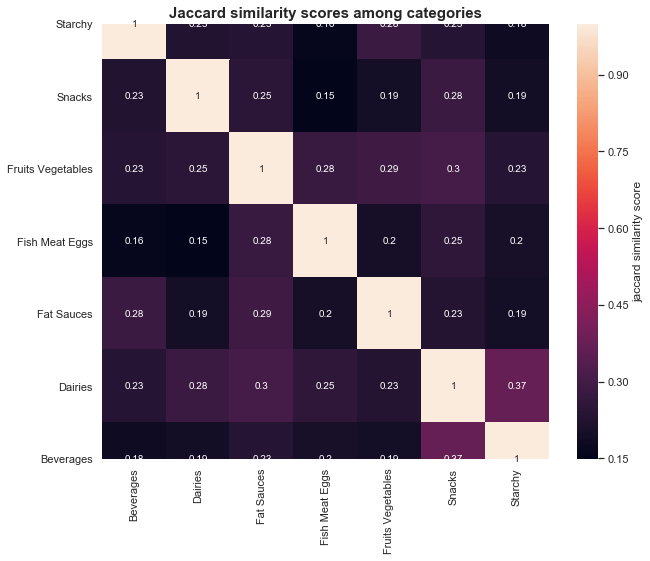

In [24]:
columns = category_words.index.values
n = len(columns)
similarity_matrix = np.zeros((n,n))

def jaccard_similarity(list1, list2):
    s1 = set(list1) # gives the keys
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

for idx1,name1 in enumerate(columns):
    for idx2,name2 in enumerate(columns):
        similarity_matrix[idx1,idx2] = jaccard_similarity(category_words[name1],category_words[name2])

plt.figure(figsize=(10,8))
sns.heatmap(similarity_matrix, annot=True, cbar_kws={'label': 'jaccard similarity score'})
plt.title("Jaccard similarity scores among categories", fontsize=15, fontweight="bold")
plt.xticks(np.arange(n)+0.5,columns,rotation='vertical')
plt.yticks(np.arange(n)+0.5,np.flip(columns,axis=0),rotation='horizontal')
plt.show()

We see that the dictionaries are rather distinct. The apparent similarities such as (Snacks/Starchy) and (Beverages/Fruits Vegetables) are senseful. Snacks and Starchy both have ingredients made with flour and Beverages such as juices can have fruit or vegetables.

To compute the similarity between a list of ingredients and a category, we compute a score. Each word in the ingredient list adds to the product's overall score its importance in the category dictionary (normalized count in the dictionary) which is also weighted by its position in the ingredients list. The idea is that the ingredients of a product are listed in order of importance, this is confirmed by the Open Food Facts website. We only consider the 10 first words in the ingredient list. We also divide the word score by the number of dictionaries in which it occurs. The ingredient is less representative of a food category if it also represents other categories.

We then categorize a product if its maximum similarity is above a certain threshold.

In [25]:
# Using similarities to category dictionaries

def similarity_dic(ingredients):
    dic = {}
    n = 10        
    for cat in category_words.index.values:
        score = 0
        for idx,word in enumerate(ingredients[:n]):
            score += category_words[cat].get(word,0)*(n-idx)/ingredientDict.get(word,1)
        dic[cat] = score
    total = sum(dic.values())
    if (total != 0) :
        dic = {k: v / total for k, v in dic.items()}
    return dic

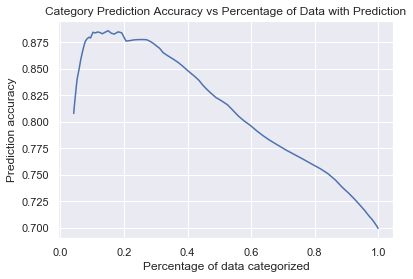

In [26]:
# We test different decision thresholds
thresholds = np.arange(0,1,0.01)
accuracies = []
percKept = []

test_similarities = classified_data.loc[~classified_data.ingredients_text.isnull(),"ingredients_text"] \
            .apply(similarity_dic).apply(pd.Series)

test_similarities = test_similarities[(test_similarities.T != 0).any()]

for t in thresholds:
    results = test_similarities.loc[test_similarities.max(axis=1)>t].idxmax(axis=1)
    accuracies.append(sum(classified_data.loc[results.index,"food_category"] == results)/len(results))
    percKept.append(len(results)/len(test_similarities))

plt.plot(percKept,accuracies)

plt.title("Category Prediction Accuracy vs Percentage of Data with Prediction")
plt.xlabel("Percentage of data categorized")
plt.ylabel("Prediction accuracy")
plt.show() 


Here, the prediction accuracy is plotted for different decision thresholds and underlines the percentage of the data categorized with regards to the accuracy. We see that even for a high decision threshold, the accuracy rises only to 87% with only about 30% of the data classified. We decide to not use this classification method and study the optimality of a Random Forest classifier.

## Random Forest approach

We decide to do vector embeddings with the dictionary obtaining in the last section. The random forest approach is a natural choice for our classification task as the classification can be intuitively done with binary decisions on product ingredients.

In [27]:
def embedding_vector(l,dic_list):
    
    vec = np.zeros(len(dic_list))
    counter = 1
    for elem in l[::-1]:
        if elem in dic_list:
            vec[dic_list.index(elem)]+=counter
            counter+= 1

    if counter != 1:
        vec = vec/np.linalg.norm(vec)
        
    return vec

# Creation of inputs and outputs
training_X = classified_data.loc[~classified_data.ingredients_text.isnull(),'ingredients_text'].apply(lambda x : embedding_vector(x,ingredientDictList))
training_Y = classified_data.loc[~classified_data.ingredients_text.isnull(),"food_category"]


In [28]:
# We replace the categories by numerical values
cat_conv = {"Fruits Vegetables":0,"Starchy":1,"Fat Sauces":2,"Snacks":3,"Dairies":4,"Beverages":5,"Fish Meat Eggs":6}
training_Y = training_Y.replace(cat_conv)

# We create numpy arrays for the training
training_X = np.stack(training_X.values)
training_Y = np.array(training_Y.values)

Some products have no ingredients in the ingredient dictionary and have to be removed from the training set

In [29]:
nonZeroRowsIndexes = np.where(training_X.any(axis=1))[0]
print("Number of kept rows : {}, {:.2f}% of training data".format(len(nonZeroRowsIndexes),100*len(nonZeroRowsIndexes)/training_X.shape[0]))
training_X = np.take(training_X,nonZeroRowsIndexes,axis=0)
training_Y = np.take(training_Y,nonZeroRowsIndexes,axis=0)

Number of kept rows : 193636, 95.83% of training data


For a first evaluation of Random Forest classifiers, we now split our data into a training set and a test set

In [30]:
X_train, X_test, y_train, y_test = train_test_split(training_X, training_Y, test_size=0.33, random_state=2)
print("Number of training samples : {}".format(X_train.shape[0]))
print("Number of testing samples : {}".format(X_test.shape[0]))

Number of training samples : 129736
Number of testing samples : 63900


In [31]:
clf = RandomForestClassifier(random_state=0,n_estimators=10,criterion="entropy")
clf.fit(X_train,y_train);
print("Accuracy score for test set : {:.2f}".format(accuracy_score(y_test,clf.predict(X_test))))

Accuracy score for test set : 0.87


Random Forest gives good results compared to our similarity method. We can always decide to not classify products whose classifier output probabilities are too low. The certainty threshold is set in a few blocks. We check the confusion matrix to see if misclassification is typical of certain categories.

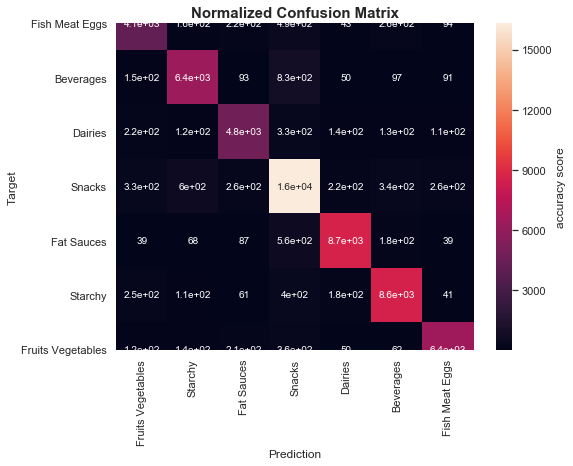

In [32]:
cm = confusion_matrix(y_test,clf.predict(X_test))
n = len(cat_conv)
columns = list(cat_conv)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cbar_kws={'label': 'accuracy score'})
plt.title("Normalized Confusion Matrix", fontsize=15, fontweight="bold")
plt.xticks(np.arange(n)+0.5,columns,rotation='vertical')
plt.yticks(np.arange(n)+0.5,np.flip(columns,axis=0),rotation='horizontal')
plt.ylabel("Target")
plt.xlabel("Prediction")
plt.show()

We notice that misclassification is rather spread out around the target/prediction possibilities and thus a simple probability threshold common to every class is sufficient to estimate certainty. We now estimate the threshold as a function of the accuracy we want, while trying to classify the most amount of products.

For validation purposes, we split out data 5 times into a training and testing set.

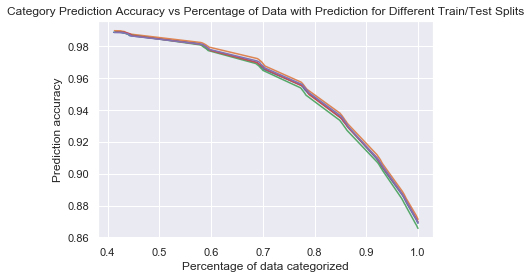

In [33]:
thresholds = np.arange(0,1.01,0.01)

for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(training_X, training_Y, test_size=0.33, random_state=i)

    clf = RandomForestClassifier(random_state=0,n_estimators=10,criterion="entropy")
    clf.fit(X_train,y_train)

    y_preds = clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)
    y_probs_max = np.max(y_probs,axis=1)

    n = len(y_test)

    accuracies = []
    percKept = []

    for t in thresholds:
        y_test_kept = np.take(y_test,np.where(y_probs_max>=t)[0])
        y_preds_kept = np.take(y_preds,np.where(y_probs_max>=t)[0])
    
        percKept.append(len(y_test_kept)/n)
        accuracies.append(accuracy_score(y_test_kept,y_preds_kept))

    plt.plot(percKept,accuracies)

plt.title("Category Prediction Accuracy vs Percentage of Data with Prediction for Different Train/Test Splits")
plt.xlabel("Percentage of data categorized")
plt.ylabel("Prediction accuracy")
plt.show() 

We see as expected that there is a tradeoff between the classification accuracy and the percentage of the data that is classified. With high accuracy we can still classify a significant amount of our data which is great news.

In [34]:
wantedAccuracy = 0.98
bestThreshold = thresholds[np.where(np.asarray(accuracies)>wantedAccuracy)[0][0]]
expectedCatPercentage = percKept[np.where(np.asarray(accuracies)>wantedAccuracy)[0][0]]

print("By choosing a certainty threshold of {0:.2f} we categorized {1:.1f}% of the testing set with {2:}% accuracy." \
      .format(bestThreshold,expectedCatPercentage*100,wantedAccuracy*100))

clf = RandomForestClassifier(random_state=0,n_estimators=10,criterion="entropy")
clf.fit(training_X,training_Y);

By choosing a certainty threshold of 0.86 we categorized 58.9% of the testing set with 98.0% accuracy.


We now classify the unclassified data with the model trained on out whole training set.

In [35]:
unclassifiedWithIngred = unclassified_data.loc[~unclassified_data.ingredients_text.isnull(),'ingredients_text'].apply(lambda x : embedding_vector(x,ingredientDictList))
indexes = unclassifiedWithIngred.index
unclassifiedWithIngred = np.stack(unclassifiedWithIngred.values)

nonZeroRowsIndexes = np.where(unclassifiedWithIngred.any(axis=1))[0]
print("Number of kept rows : {}, {:.2f}% of unclassified data with ingredients_text".format(len(nonZeroRowsIndexes),100*len(nonZeroRowsIndexes)/unclassifiedWithIngred.shape[0]))

Number of kept rows : 243559, 96.62% of unclassified data with ingredients_text


In [36]:
# We makes the predictions and only keep those with max probability above the certainty threshold found earlier
dataToPredict = np.take(unclassifiedWithIngred,nonZeroRowsIndexes,axis=0)
indexes = np.take(indexes,nonZeroRowsIndexes,axis=0)
preds = clf.predict(dataToPredict)
probs = clf.predict_proba(dataToPredict)
probs_max = np.max(probs,axis=1)

y_preds_kept = np.take(preds,np.where(probs_max>=bestThreshold)[0])
indexes_kept = np.take(indexes,np.where(probs_max>=bestThreshold)[0])
    
print("We classifed {:.2f}% of the unclassified data with ingredients_text".format(100*len(y_preds_kept)/unclassifiedWithIngred.shape[0]))

We classifed 31.54% of the unclassified data with ingredients_text


In [37]:
# We translate our numerical categories back to strings
cat_conv_inv = {0:"Fruits Vegetables",1:"Starchy",2:"Fat Sauces",3:"Snacks",4:"Dairies",5:"Beverages",6:"Fish Meat Eggs"}
y_preds_kept = np.vectorize(cat_conv_inv.get)(y_preds_kept)

In [38]:
# We update our dataset
data.loc[indexes_kept,"food_category"] = y_preds_kept

classificationRatio = sum(data["food_category"].value_counts())/len(data)
print("We managed to classify {:.2f}% of the whole data".format(classificationRatio*100))

We managed to classify 43.32% of the whole data


In [39]:
data.loc[np.random.choice(indexes_kept,10,replace=False),["food_category","product_name"]]

,food_category,product_name
905195,Starchy,Couscous Complet
770547,Snacks,Cookies Super Fruit
379660,Snacks,Le mini muffin pépites de choco
21726,Fish Meat Eggs,Ham Off The Bone
847243,Beverages,Klostergarten Beruhigungstee
852110,Snacks,Amour de biber(naturaplan)
855234,Beverages,"Cave du Clos de Céligny, Sauvignon Blanc, AOC ..."
851150,Dairies,Qualité & Prix Jogurt Nature partiellement écrémé
108586,Snacks,"Old Fashioned Ket-L Potato Chips, Bar-B-Q"
46215,Beverages,Chamomile Mint Green Tea With Other Natural Fl...


# PACKAGING

While this field remains incomplete, it is still useful for us to analyze the packaging methods of different food categories. The processing pipeline for this field was performed as follows :
- clean 'Packaging' column of the dataframe by removing stop words and unecessary entries
- retain only certain material types of packaging (plastic, glass, cardboard, metal ...)
- plot the proportion of each material within a certain category of food

In [40]:
# We build our list of stopwords to remove when tockenizing the packaging column
stop_words_c = set(stopwords.words("french")).union(set(stopwords.words("english")))

# 'can' was removed since it was in the stop words list but still useful for Beverages containers
stop_words_c.remove('can')

In [41]:
# We clean the packaging column
def clean_data_packaging(data_column):
    """Clean data packaging, i.e. 
        - lower each words in the cells of data_column
        - tokenize cells of data_column, i.e. from float type create list of string (token)
        - remove stopwords for the list of tokens for each cells of data_column
    """  
    
    tokenizer = RegexpTokenizer(r'\w+')
    data_column = data_column[data_column.notnull()].str.lower() \
    .apply(str) \
    .apply(tokenizer.tokenize) \
    .apply(lambda cell : [item for item in cell if item not in stop_words_c]) \
    .apply(str)
    
    return data_column


packaging = clean_data_packaging(data.packaging)
packaging = packaging.apply(literal_eval)
filled_pck = data.packaging.count()/len(data.packaging)

# We visualize some results
print(f'Packaging field is full at {filled_pck} %')
packaging.head()

Packaging field is full at 0.20111789526571036 %


17     [barquette, plastique]
142        [bocal, plastique]
146               [plastique]
300       [carton, plastique]
301       [plastique, carton]
Name: packaging, dtype: object

**20% of the data has packaging information**
We now categorize the packaging information to defined packaging classes.

In [42]:
# Vaccum items were added since it surely contains plastic
plastique_words = ['plastic', 'plastique', 'plastik', 'plastico', 'plastica', 'sachets', 
                   'plàstic', 'plástico', 'plastisco' ,'bucket', 'barquette', 'sachet', 'tube', 'film', 'vacio', 'vide', 'vacío']

verre_words = ['verre', 'glass', 'glas', 'vidrio', 'pot']
carton_words = ['paper', 'karton', 'carton', 'papier', 'boite', 'cartón', 'papel', 'cardboard', 
                'card', 'eggbox', 'box']

metal_words = ['metal', 'métal', 'fer', 'acier', 'aluminium', 'can', 'canette', 'conserve','tin']

# Fresh products needs an adapted container which is useful for further exploration
prod_frais_words = ['frais', 'fresh', 'frai']

# The recycable materials depend on the country and regulations. However, these materials are commonly recycable.
# (soiled papers, soiled metalic containers and soiled plastic containers tend to be avoided for medical reasons)
recyclable_words = ['bouteille', 'flacon', 'brique', 'brick', 'bottle', 'bte', 'verre', 
                    'glass', 'glas', 'vidrio', 'metal', 'métal', 'fer', 'acier', 'aluminium', 'flasche', 'canned', 
                    'can', 'canette', 'conserve', 'tin', 'pet', 'pot', 'botella']

def count_entries(self, word_list):
    """ Return true if word_list and self have a word in common,
        else o/w.
    """
    if len(set(self).intersection(set(word_list))) > 0:
        return True
    else :
        return False

def to_materials(elem):
    """ Return a list of bool that informs about the materials used 
        for the packaging.
    """
    return [count_entries(elem, plastique_words), 
               count_entries(elem, verre_words), 
               count_entries(elem, carton_words),
               count_entries(elem, metal_words),
               count_entries(elem, prod_frais_words),
               count_entries(elem, recyclable_words)]
    

In [43]:
# We a create a boolean list for each value representing the membership to packaging methods and fresh/recycable attribute
materials_df = pd.DataFrame({'Packaging': packaging, 'materials':pd.Series(np.zeros(len(packaging)), packaging.index)})
materials_df['materials'] = packaging.apply(to_materials)

In [44]:
# We create a dataframe with the information
names_list = ['Plastic', 'Glass', 'Carton', 'Metal', 'Fresh', 'Recyclable']
materials_df = materials_df.materials.apply(pd.Series)
materials_df = materials_df.rename(columns = lambda x : names_list[x])

In [45]:
# We merge with the food categories
eco_impact_plot_df = materials_df.merge(data.loc[materials_df.index.tolist(), ["food_category"]], left_index = True, right_index = True)

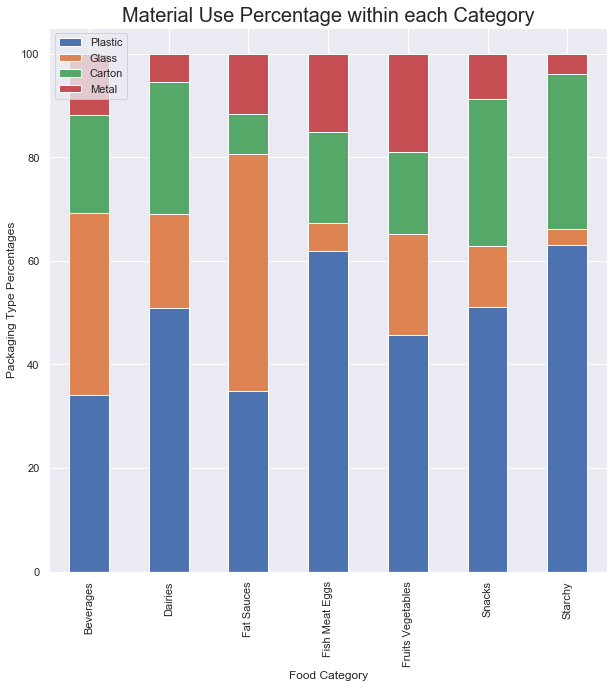

In [46]:
# We remove Fresh and Recycable categories and plot normalized bar plots for the packaging for each food category
packaging_plot_df = eco_impact_plot_df.drop('Fresh', axis =1)
packaging_plot_df = packaging_plot_df.drop('Recyclable', axis =1)
counts_pack = packaging_plot_df.groupby('food_category').sum()

plt.figure(figsize =(10,10))
ax=plt.gca()
counts_pack.div(counts_pack.sum(axis=1)/100, axis = 0).plot.bar(ax=ax, stacked=True)
plt.title('Material Use Percentage within each Category',fontsize=20);
plt.xlabel("Food Category");
plt.ylabel("Packaging Type Percentages");

While the sample size is limited, a few useful informations are depicted on the above plot. First we can see that a lot of plastic is used among every category. Moreover, glass is mainly used as a liquid container which is consistent with what we could expect. The packaging information along with the use of cooling containers and recyclability of products will be used in the analysis of different diets.

# NUTRISCORE


A simple, readable, understandable graphic system

A triple objective
- Inform the consumer at the time of purchase to include the nutrition
dimension in the selection criteria (in addition to price, practicality,
taste, notoriety, label ...)
- Encourage producers to improve the nutritional quality of products
- Facilitate Health Professional advice on Nutrition

For the consumer a triple purpose:
- Compare the nutritional quality of foods from different categories
(ex : biscuits/dairy products/beverages....)
- Compare the nutritional quality of foods belonging to the same
category (ex : breakfast cereals)
- Compare the nutritional quality of the same food offered by
different brands ( ex : filled cereals)


The score comprises two dimensions: negative points (corresponding to the 'unfavourable' components, an
excess of which is considered unhealthy: calories, sugars, sodium and saturated fatty acids) and positive
points (corresponding to 'favourable' components: fruits, vegetables, pulses, nuts, and rapeseed, walnut
and olive oils, protein and fibre, an adequate amount of which is considered healthy).
- Between 0 and 10 points are awarded for each of these 4 'unfavourable' components, based on the
amount in 100 g of the food. Points are assigned based on the reference intake for the nutrient in
question. First, the 'unfavourable' components are totalled, resulting in a number of positive points
(maximum of +40).
- Between 0 and 5 points are awarded for the 3 'favourable' components (0 to 10 points for
beverages), based on the amount in 100 g of the food (maximum of -15).

Depending on the number of positive points, either all of the 'favourable' components are subtracted, or
only the fibre and, the “fruits, vegetables, pulses, nuts, and rapeseed, walnut and olive oils” components,
according to the following rules.
- If the total for the N component is less than 11 points, then the nutritional score is equal to the
total N component points minus the total for the P component.
- If the total for the N component is greater than or equal to 11 points and
    - If the total for “Fruits, vegetables, pulses, nuts, and rapeseed, walnut and olive oils” is equal to 5 (10 for beverages), then the nutritional score is equal to the total N component points minus the total for the P component.
    - If the total for “Fruits, vegetables, pulses, nuts, and rapeseed, walnut and olive oils” is less than 5 (10 for beverages), then the nutritional score is equal to the total N component points minus the sum of the points for “fibres” and “Fruits, vegetables, pulses, nuts, and rapeseed, walnut and olive oils”. In this case, the protein content is therefore not taken into account in the calculation of the nutritional score.

The point table generally used to calculate the nutritional score is as follows:
- Points assigned for nutrients that have a negative impact on the nutritional score (N)


| Points N | Energy density (kJ/100g) | Sugars (g/100g) | Saturated fatty acids (g/100g) | Sodium (mg/100g) |
|:--------:|:------------------------:|:---------------:|:------------------------------:|:----------------:|
|     0    |           < 335          |      < 4.5      |               < 1              |       < 90       |
|     1    |           > 335          |      > 4.5      |               > 1              |       > 90       |
|     2    |           > 670          |       > 9       |               > 2              |       > 180      |
|     3    |          > 1005          |      > 13.5     |               > 3              |       > 270      |
|     4    |          > 1340          |       > 18      |               > 4              |       > 360      |
|     5    |          > 1675          |      > 22.5     |               > 5              |       > 450      |
|     6    |          > 2010          |       > 27      |               > 6              |       > 540      |
|     7    |          > 2345          |       > 31      |               > 7              |       > 630      |
|     8    |          > 2680          |       > 36      |               > 8              |       > 720      |
|     9    |          > 3015          |       > 40      |               > 9              |       > 810      |
|    10    |          > 3350          |       > 45      |              > 10              |       > 900      |





- Points attributed for nutrients that have a positive impact on the nutritional score (P) 

| Points P | Fruits, vegetables, pulses, nuts (%) | Fibre (g/100g) | Protein (g/100g) |
|:--------:|:------------------------------------:|:--------------:|:----------------:|
|     0    |                 < 40                 |      < 0.9     |       < 1.6      |
|     1    |                 > 40                 |      > 0.9     |       > 1.6      |
|     2    |                 > 60                 |      > 1.9     |       > 3.2      |
|     3    |                   -                  |      > 2.8     |       > 4.8      |
|     4    |                   -                  |      > 3.7     |       > 6.4      |
|     5    |                 > 80                 |      > 4.7     |        > 8       |

Methods for calculating the score: adaptations

- Fat and Sauces
    - The total saturated fatty acids/lipids calculation replaces the saturated fatty acids column, but the other columns must be used.
    
| Points N | Ratio (%) total saturated fatty acids/lipids  |
|:--------:|:---------------------------------------------:|
|     0    |                      < 10                     |
|     1    |                      < 16                     |
|     2    |                      < 22                     |
|     3    |                      < 28                     |
|     4    |                      < 34                     |
|     5    |                      < 40                     |
|     6    |                      < 46                     |
|     7    |                      < 52                     |
|     8    |                      < 58                     |
|     9    |                      < 64                     |
|    10    |                      > 64                     |

- Beverages
    - The calculation of the energy, total sugars and fruit and vegetables columns replaces the previous columns, but the other columns must be used. 
    
| Points | Energy density (kJ/100g or 100mL) | Sugars (g/100g or 100mL) | Fruits, vegetables, pulses, nuts (%) |
|:------:|:---------------------------------:|:------------------------:|:------------------------------------:|
|    0   |                < 0                |            < 0           |                 < 40                 |
|    1   |                < 30               |           < 1.5          |                   -                  |
|    2   |                < 60               |            < 3           |                 > 40                 |
|    3   |                < 90               |           < 4.5          |                   -                  |
|    4   |               < 120               |            < 6           |                 > 60                 |
|    5   |               < 150               |           < 7.5          |                   -                  |
|    6   |               < 180               |            < 9           |                   -                  |
|    7   |               < 210               |          < 10.5          |                   -                  |
|    8   |               < 240               |           < 12           |                   -                  |
|    9   |               < 270               |          < 13.5          |                   -                  |
|   10   |               > 270               |          > 13.5          |                 > 80                 |


- Cheeses
    - Cheese nutritional score = Total N points – Total P points

Assigning Colours


The Nutri-Score logo is attributed based on the score obtained (see table below).

| Solid foods points | Beverages points | Logo |
|:------------------:|:----------------:|:----:|
|      Min to -1     |      Waters      |   A  |
|        0 - 2       |      Min - 1     |   B  |
|       3 - 10       |       2 - 5      |   C  |
|       11 - 18      |       6 - 9      |   D  |
|      19 - Max      |     10 - Max     |   E  |

## Data SetUp

### Water Tag
In order to compute the NutriScore (NS) of products, we need to seperate water from other beverages.

In [47]:
# Words which reference water
water_list = ["water","waters","eau","agua"]

# Some 'categories' values contain words refering to water but are liquors
# We thus create a list to discard such products
nonwater_list = ["alkoholische","alcoholic","spirits","liquors","tonic",'coconut','sodas','soda']

# We clean the 'categories' column and split into words
data["split_categories"] = data["categories"]
clean_text(data,"split_categories")
data.loc[:,"split_categories"] = data.loc[:,"split_categories"].str.split()

data["iswater"] = data.loc[~data["split_categories"].isnull(),"split_categories"] \
.apply(lambda l : bool(~any([cat_word in nonwater_list for cat_word in l]) &  \
                       any([cat_word in water_list for cat_word in l])))




In [48]:
data[data["iswater"]==True][['product_name','categories']].head(4)

,product_name,categories
12177,Bottled Drinking Water,en:waters
14418,Pure Water,"Beverages, Waters, Unsweetened beverages"
16869,Black raspberry naturally flavoured sparkling ...,"Beverages,Carbonated drinks,Waters,Carbonated ..."
21347,Drinking Water,"Beverages, Waters"


In [49]:
# replace NaN of 'fruits-vegetables-nuts_100g' by 100 if it is 'Fruit juices'
#data[(data['main_category_en'] == 'Fruit juices')]['fruits-vegetables-nuts_100g'].fillna(0, inplace=True)

In [50]:
selected_fields =[
    'product_name','food_category',
    'energy_100g','sugars_100g','saturated-fat_100g','fat_100g','sodium_100g',
    'fruits-vegetables-nuts_100g',
    'fiber_100g','proteins_100g',
    'nutrition-score-uk_100g',
    'nutrition_grade_fr',
    'iswater']

In [51]:
# divide dataframe into 3 groups to simplify the calculation of nutriscrore
data_beverages = data[data['food_category']=='Beverages'][selected_fields]
data_beverages['fatsaturated/lipids'] = data_beverages['saturated-fat_100g']/data_beverages['fat_100g']*100

data_fatsauces = data[data['food_category']=='Fat Sauces'][selected_fields]
data_fatsauces['fatsaturated/lipids'] = data_fatsauces['saturated-fat_100g']/data_fatsauces['fat_100g']*100

categories_without_beveragesfatsauce =['Snacks','Dairies','Fish Meat Eggs','Starchy','Fruits Vegetables']
data_without_beverage_fat = data[data['food_category'].isin(categories_without_beveragesfatsauce)][selected_fields]
data_without_beverage_fat['fatsaturated/lipids'] = data_without_beverage_fat['saturated-fat_100g']/data_without_beverage_fat['fat_100g']*100


We keep the index of the products that present all the non Nan features to be able to know if the NS calculation process is accurate whit the Nutri-grade already given

In [52]:
verification_index = data[selected_fields]
verification_index = nutridattta.loc[(nutridattta.isnull()).sum(axis=1)==0]


NameError: name 'nutridattta' is not defined

### Calculation of negative points

We attribute Negative points (N) to different nutritional factors that have to be limited: energy, sugar, saturated fat and sodium

In [53]:
## ENERGY
# energy bins
energy_bins_without_beverage_fat = [data_without_beverage_fat['energy_100g'].min() - 1, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data_without_beverage_fat['energy_100g'].max()]
energy_bins_fatsauces = [data_fatsauces['energy_100g'].min() - 1, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data_fatsauces['energy_100g'].max()]
energy_bins_beverages = [data_beverages['energy_100g'].min() - 1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, data_beverages['energy_100g'].max()]
# energy point
data_without_beverage_fat['energy_points'] = pd.cut(data_without_beverage_fat['energy_100g'], energy_bins_without_beverage_fat, labels=range(11)).astype(float)
data_fatsauces['energy_points'] = pd.cut(data_fatsauces['energy_100g'], energy_bins_fatsauces, labels=range(11)).astype(float)
data_beverages['energy_points'] = pd.cut(data_beverages['energy_100g'], energy_bins_beverages, labels=range(11)).astype(float)


## SUGAR  
# sugar bins
sugar_bins_without_beverage_fat = [data_without_beverage_fat['sugars_100g'].min() - 1, 4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45,  data_without_beverage_fat['sugars_100g'].max()]
sugar_bins_fatsauces = [data_fatsauces['sugars_100g'].min() - 1,4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45, data_fatsauces['sugars_100g'].max()+46]
sugar_bins_beverages = [data_beverages['sugars_100g'].min() - 1, 0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5, data_beverages['sugars_100g'].max()]
# sugar point (CHANGE SUGAR_BINS)
data_without_beverage_fat['sugar_points'] = pd.cut(data_without_beverage_fat['sugars_100g'], sugar_bins_without_beverage_fat, labels=range(11)).astype(float)
data_fatsauces['sugar_points'] = pd.cut(data_fatsauces['sugars_100g'], sugar_bins_fatsauces, labels=range(11)).astype(float)
data_beverages['sugar_points'] = pd.cut(data_beverages['sugars_100g'], sugar_bins_beverages, labels=range(11)).astype(float)


## SATURATED FAT
# s-fat bins
fat_bins_without_beverage_fat = [data_without_beverage_fat['saturated-fat_100g'].min() - 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data_without_beverage_fat['saturated-fat_100g'].max()]
fat_bins_beverages = [data_beverages['saturated-fat_100g'].min() - 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data_beverages['saturated-fat_100g'].max()]
fat_bins_fatsauces = [data_fatsauces['saturated-fat_100g'].min() - 1, 10, 16, 22, 28, 34, 40, 46, 52, 58, 64, data_fatsauces['saturated-fat_100g'].max()]
# s-FAT point (CHANGE FAT_BINS)
data_without_beverage_fat['saturated-fat_points'] = pd.cut(data_without_beverage_fat['saturated-fat_100g'], fat_bins_without_beverage_fat, labels=range(11)).astype(float)
data_beverages['saturated-fat_points'] = pd.cut(data_beverages['saturated-fat_100g'], fat_bins_beverages, labels=range(11)).astype(float)
data_fatsauces['saturated-fat_points'] = pd.cut(data_fatsauces['fatsaturated/lipids'], fat_bins_fatsauces, labels=range(11)).astype(float)


## SODIUM
# sodium bins
sodium_bins = [data['sodium_100g'].min() - 1, 0.090, 0.180, 0.270, 0.360, 0.450, 0.540, 0.630, 0.720, 0.810, 0.900, data['sodium_100g'].max()]
# sodium points
data_without_beverage_fat['sodium_points'] = pd.cut(data_without_beverage_fat['sodium_100g'], sodium_bins, labels=range(11)).astype(float)
data_beverages['sodium_points'] = pd.cut(data_beverages['sodium_100g'], sodium_bins, labels=range(11)).astype(float)
data_fatsauces['sodium_points'] = pd.cut(data_fatsauces['sodium_100g'], sodium_bins, labels=range(11)).astype(float)



### Calculation positive points

We attribute Positive points (P) to different nutritional factors that have to be promoted: fruit vegetable nuts pourcentage, fibers and proteins.

In [54]:
# FRUITS
# fruits bins
fruits_bins_without_beverage_fat = [data_without_beverage_fat['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_without_beverage_fat['fruits-vegetables-nuts_100g'].max()]
fruits_bins_fatsauces = [data_fatsauces['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_fatsauces['fruits-vegetables-nuts_100g'].max()]
fruits_bins_beverages = [data_beverages['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_beverages['fruits-vegetables-nuts_100g'].max()]
# fruits points
data_without_beverage_fat['fruits_points'] = pd.cut(data_without_beverage_fat['fruits-vegetables-nuts_100g'], fruits_bins_without_beverage_fat, labels=[0,1,2,5]).astype(float)
data_beverages['fruits_points'] = pd.cut(data_beverages['fruits-vegetables-nuts_100g'], fruits_bins_beverages, labels=[0,2,4,10]).astype(float)
data_fatsauces['fruits_points'] = pd.cut(data_fatsauces['fruits-vegetables-nuts_100g'], fruits_bins_fatsauces, labels=[0,1,2,5]).astype(float)


# FIBRES
# fibers bins
#fibers_bins = [data['fiber_100g'].min() - 1, 0.7, 1.4, 2.1, 2.8, 3.5, data['fiber_100g'].max()]
fibers_bins = [data['fiber_100g'].min() - 1, 0.9, 1.9, 2.8, 3.7, 4.7, data['fiber_100g'].max()]

# fibers points
data_without_beverage_fat['fiber_points'] = pd.cut(data_without_beverage_fat['fiber_100g'], fibers_bins, labels=range(6)).astype(float)
data_beverages['fiber_points'] = pd.cut(data_beverages['fiber_100g'], fibers_bins, labels=range(6)).astype(float)
data_fatsauces['fiber_points'] = pd.cut(data_fatsauces['fiber_100g'], fibers_bins, labels=range(6)).astype(float)

# PROTEINS
# proteins bins
proteins_bins = [data['proteins_100g'].min() - 1, 1.6, 3.2, 4.8, 6.4, 8.0, data['proteins_100g'].max()]
# proteins points
data_without_beverage_fat['proteins_points'] = pd.cut(data_without_beverage_fat['proteins_100g'], proteins_bins, labels=range(6)).astype(float)
data_beverages['proteins_points'] = pd.cut(data_beverages['proteins_100g'], proteins_bins, labels=range(6)).astype(float)
data_fatsauces['proteins_points'] = pd.cut(data_fatsauces['proteins_100g'], proteins_bins, labels=range(6)).astype(float)


In [55]:
# rejoin last separated dataframe
frames = [data_without_beverage_fat, data_beverages, data_fatsauces]
nutridata = pd.concat(frames)

### Nutriscore calculation

We made the concession to put 0 inplace of Nan of 'fruits_points','fiber_points','proteins_points' if there were missing data in the original database, this will not be a problem we do not substract Positive point.
We made this concession to be able to calculate the NS of product, with the missing positive points fill to zero we have a more badly estimation on the NS but still accurate

In [56]:
nutridata['fruits_points'] = nutridata['fruits_points'].fillna(0)
nutridata['fiber_points'] = nutridata['fiber_points'].fillna(0)
nutridata['proteins_points'] = nutridata['proteins_points'].fillna(0)

In [57]:
# calculation of P x N
nutridata['points_N']= nutridata['energy_points'] + nutridata['saturated-fat_points'] + nutridata['sugar_points'] + nutridata['sodium_points']
nutridata['points_P'] = nutridata['fruits_points'] + nutridata['fiber_points'] + nutridata['proteins_points']

In [58]:
def compute_score(row):
    N = row['points_N']
    P = row['points_P']
    fruit = row['fruits_points']
    fiber = row['fiber_points']
    cat = row['food_category']
        
    if N < 11 or cat == 'Dairies':
        return N - P
    else:
        if  fruit == 5:
            return N - P
        else:
            return N - (fiber + fruit)
    
nutridata['nutri-score_calculated'] = nutridata.apply(compute_score, axis=1)

### Convertion of NutriScore into NutriLetter


In [59]:
# re divided dataframe to allow a simpler transformation of score into letter
nutridata_beverages = nutridata[ (nutridata['food_category']=='Beverages') & (nutridata['iswater']!=True)]
nutridata_not_beverages = nutridata[ nutridata['food_category']!='Beverages']
nutridata_beverages_water = nutridata[ (nutridata['food_category']=='Beverages') & (nutridata['iswater']==True)]

In [60]:
# NUTRILETTER

#letter bins
letter_bins_aliments = [nutridata['nutri-score_calculated'].min() - 1, -1, 2, 10, 18, nutridata['nutri-score_calculated'].max()]
letter_bins_beverages = [nutridata['nutri-score_calculated'].min() - 1, 2, 5, 9, nutridata['nutri-score_calculated'].max()]
letter_bins_beverages_water = [nutridata['nutri-score_calculated'].min() - 1, nutridata['nutri-score_calculated'].max()]

#letter
nutridata_not_beverages['nutri-score_letter_CALCULATED'] = pd.cut(nutridata_not_beverages['nutri-score_calculated'], letter_bins_aliments, labels=['a','b','c','d','e'])
nutridata_beverages['nutri-score_letter_CALCULATED'] = pd.cut(nutridata_beverages['nutri-score_calculated'], letter_bins_beverages, labels=['b','c','d','e'])
nutridata_beverages_water['nutri-score_letter_CALCULATED'] = pd.cut(nutridata_beverages_water['nutri-score_calculated'], letter_bins_beverages_water, labels=['a'])


C:\Users\Yann Schilling\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Yann Schilling\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Yann Schilling\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [61]:
nutriframes = [nutridata_not_beverages, nutridata_beverages, nutridata_beverages_water]
nutridata = pd.concat(nutriframes)

nutridata['nutri-score_letter_CALCULATED'].value_counts().sum()

324045

At the end of this process of NS calculation we obtain a NS for 315k product

### Visualisation of proportion of NutriLetter label for each Food Category

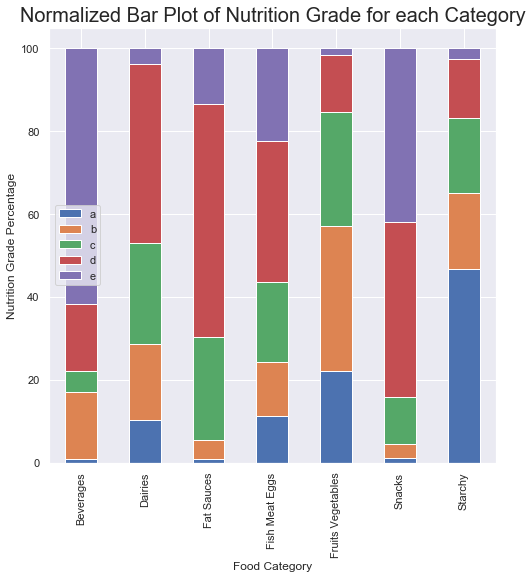

In [62]:
lettercounts =nutridata.groupby(['food_category','nutri-score_letter_CALCULATED']).count()['nutri-score_calculated']

plt.figure(figsize=(8,8))
ax=plt.gca()

lettercounts.unstack().div(lettercounts.unstack().sum(axis=1)/100,axis=0).plot.bar(ax=ax,stacked=True)
plt.legend(loc='center left')
plt.title("Normalized Bar Plot of Nutrition Grade for each Category",fontsize=20);
plt.xlabel("Food Category");
plt.ylabel("Nutrition Grade Percentage");

## Comparation nutriletter rawdata vs calculated

Firstly we compare the calculated NS of the products with zero missing nutritional values

In [63]:
verification = nutridata.loc[verification_index.index,:]
size_with_all_features = len (verification)
size_same_letter = len(verification[verification['nutri-score_letter_CALCULATED']==verification['nutrition_grade_fr']])
print("{} products have all the features non Nan and {} have the same letter calculated compare to the Nutrigrade already given \
that represent {:.2f}% of accuraty with the calculation methods".format(size_with_all_features,size_same_letter,size_same_letter/size_with_all_features*100))

C:\Users\Yann Schilling\Anaconda3\envs\ada\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


939444 products have all the features non Nan and 222196 have the same letter calculated compare to the Nutrigrade already given that represent 23.65% of accuraty with the calculation methods


We saw that this this calculation process 95% of NS are identical meanning that we can apply on all the products

Secondly we compare the calculated NS of the products with missing nutritional values

In [64]:
product_2nutriletter =len(nutridata[(nutridata['nutri-score_letter_CALCULATED'].notnull()) & (nutridata['nutrition_grade_fr'].notnull())])
product_samenutriletter =len(nutridata[(nutridata['nutri-score_letter_CALCULATED'].notnull()) & (nutridata['nutrition_grade_fr'].notnull()) & (nutridata['nutri-score_letter_CALCULATED']==nutridata['nutrition_grade_fr'])])
print("For products with missing values we obtain {:.2f}% accuracy between the calculated NS and the one given".format(product_samenutriletter/product_2nutriletter*100))

For products with missing values we obtain 86.81% accuracy between the calculated NS and the one given


We now check why some product have different Nutri-score 

In [65]:
#nutri_df = nutridata[(nutridata['nutri-score_letter_CALCULATED'].notnull()) & (nutridata['nutrition_grade_fr'].notnull()) & (nutridata['nutri-score_letter_CALCULATED']!=nutridata['nutrition_grade_fr'])][['product_name','food_category','nutrition_grade_fr','nutri-score_letter_CALCULATED']]
nutri_df = nutridata[(nutridata['nutri-score_letter_CALCULATED'].notnull()) & (nutridata['nutrition_grade_fr'].notnull()) ][['product_name','food_category','nutrition_grade_fr','nutri-score_letter_CALCULATED']]
nutri_df.head()

,product_name,food_category,nutrition_grade_fr,nutri-score_letter_CALCULATED
17,Tarte noix de coco,Snacks,d,d
25,Compote de poire,Fruits Vegetables,a,c
51,Abondance,Dairies,d,d
53,cuisse de poulet direct au four curry,Fish Meat Eggs,c,c
54,Bagel,Starchy,b,b


In [69]:
nutridata.iloc[24,:]

product_name                     Organic Mung Beans
food_category                               Starchy
energy_100g                                    1477
sugars_100g                                     NaN
saturated-fat_100g                              NaN
fat_100g                                       0.98
sodium_100g                                 0.02032
fruits-vegetables-nuts_100g                     NaN
fiber_100g                                     15.7
proteins_100g                                 23.53
nutrition-score-uk_100g                         NaN
nutrition_grade_fr                              NaN
iswater                                         NaN
fatsaturated/lipids                             NaN
energy_points                                     4
sugar_points                                    NaN
saturated-fat_points                            NaN
sodium_points                                     0
fruits_points                                     0
fiber_points

For the product n°24 a 'Compote de poire' we saw that the missing value in 'fruits-vegetables-nuts_100g' features is the problem with no positive point substract.

We can know quantify for how many products we have calculated the nutriscore without the NS in their original features

In [70]:
NS_given = len(nutridata[ (nutridata['nutrition_grade_fr'].notnull())])
NS_calculated =len(nutridata[(nutridata['nutri-score_letter_CALCULATED'].notnull()) & (nutridata['nutrition_grade_fr'].isnull())])
print("We have added {} Nutri-score in the dataset, representing an increase of {:.2f}%".format(NS_calculated,NS_calculated/NS_given*100))
      
      

We have added 68082 Nutri-score in the dataset, representing an increase of 26.25%


In [71]:
nutri_df['NG_fr'] = pd.factorize(nutri_df['nutrition_grade_fr'], sort=True)[0] + 1
nutri_df['NG_calc'] = pd.factorize(nutri_df['nutri-score_letter_CALCULATED'], sort=True)[0] + 1

In [72]:
nutri_df['Diff'] = (nutri_df['NG_fr'] - nutri_df['NG_calc'])

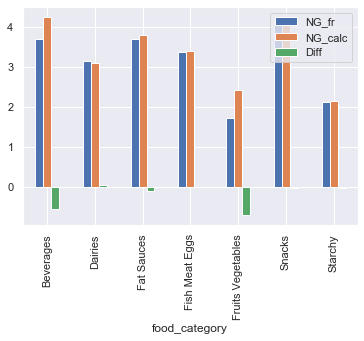

In [73]:
nutri_df.drop(['product_name', 'nutrition_grade_fr', 'nutri-score_letter_CALCULATED'], axis = 1).groupby('food_category').mean().plot(kind='bar')

-------------------------------------------
# Diet Study 

In this part, we are interested in diet classifications according to information we took from some useful columns of the datasetsuch as _categories_, _labels_en_, _ingredients_text_ and _product_name_.
5 diets will be found using our classification strategy, among them we have: 
* Vegetarian diet
* Vegetalian diet
* Gluten-free diet
* Lactose-free diet
* Ketogenic diet

Our classification strategy rely on the following principle: 
>Since diets are mostly defined by forbidden food depending on the diets, we manage to find forbidden words presents in those columns in order to be able to state that the corresponding product doesn't belong to the specific diet in question. To do so, we managed to create some lists of forbidden words for each diet, and for each concerned columns, we will call them ___notRegimes_lists___. An exception occurs when dealing with the _labels_en_ column, since the informations found in this column directly correspond to the specific diet in which belong the product, such as __gluten-free__, __lactose-free__ or __vegetarian__ or __vegan__ (which stand for vegetalian diet). Therefore, list of accepted words are created to treat this column. Those accepted words will directly state if the product belong to the diet or not. We will call those lists ___isRegimes_lists___

## Data cleaning preprocess

The first step of our diet study is indeed to preprocess the column of interest in order to reduce the vocabulary of this column. Indeed, since we want to create the lists manually, we want to minimize the number of words we want to look at by stemming or lemmentize them for example. 

### Helper functions for data cleaning preprocess

In [74]:
def clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving=False, langdetec=False, tokenize=False, stemming=False, \
               lemmatizing=False, onlyEngStemmer=False, onlyFrStemmer=False, applyNounFilter=False):
    """function that appeals all cleaning methods depending of the booleans stated above. The parameters of this function are the following one
        - data = pandas dataframe containing the column of interest in particular
        - column_to_clean = string corresponding to the name of the column to clean
        - stop_words = stop words to remove during the tokenization process
        - tokenizer = tokenizer used to tokenize the column of interest
        - wordnet_lemmatizer = lemmatizer used to lemmatize the tokens
        - saving = boolean to set to True in order to save the preprocess outputs in pickle format
        - langdetec = boolean to set to True in order to detect the language used in each cell of the corresponding column
        - tokenize = boolean to set to True in order to tokenize the column
        - stemming = boolean to set to True in order to stem the column
        - lemmatizing = boolean to set to True in order to lemmatize the column
        - onlyEngStemmer = boolean to set to True in order to stem the column only with an english stemmer 
                           (used in cases we didn't detect the language)
        - onlyEngStemmer = boolean to set to True in order to stem the column only with an french stemmer 
                           (used in cases we didn't detect the language)
        - applyNounFilter = boolean to set to True in order to keep only tokens corresponding to noun.
    """
    cleaned_data = pd.DataFrame()    
    cleaned_data[column_to_clean] = data[column_to_clean].copy()
    
    if langdetec:
        cleaned_data["languages"] = data[data[column_to_clean].notnull()][column_to_clean].apply(language_detection)
        #We found all the languages disponibles for stemming, and mapped the corresponding name to the ISO_code found by langdetect.detect
        cleaned_data["languages"] = cleaned_data["languages"].map({"ar": "arabic", "da": "danish", "nl" : "dutch", "en": "english", "fi": "finnish", "fr": "french", "de": "german", \
                                  "hu": "hungarian", "it": "italian", "no": "norwegian", "ro": "romanian", "ru" : "russian", "es": "spanish", \
                                  "sv" :"swedish"})
        if saving:
            cleaned_data.to_pickle("saved_process/processed_pickles/"+str(column_to_clean)+"/out_langdetect.pkl")
       
    if tokenize:
        #tokenize column_to_clean : --> stemming + lemmatization need list of tokens
        cleaned_data[column_to_clean] = tokenize_data(cleaned_data[column_to_clean], stop_words, tokenizer, applyNounFilter)
        if saving:
            cleaned_data.to_pickle("saved_process/processed_pickles/"+str(column_to_clean)+"/out_token.pkl")
    else: 
        cleaned_data = pd.read_pickle("saved_process/processed_pickles/"+str(column_to_clean)+"/out_token.pkl") 
    
    if stemming:
        #For stemming, langdetection as to be made previously preferentially, except in cases in which the majority of the column is
        #written in english (onlyEngStemmer=True), or in french (onlyFrStemmer=True)
        if (not(langdetec or onlyEngStemmer or onlyFrStemmer)):
            lang_data = pd.read_pickle("saved_process/processed_pickle/"+str(column_to_clean)+"/out_langdetect.pkl")
            cleaned_data["languages"] = lang_data["languages"].copy()
        
        cleaned_data = stemming_data(cleaned_data, column_to_clean, onlyEngStemmer, onlyFrStemmer)
        if saving:
            cleaned_data.to_pickle("saved_process/processed_pickles/"+str(column_to_clean)+"/out_stem.pkl")  
            
    elif lemmatizing: 
        #lemmatizing only works well for english words
        cleaned_data = lemmatizing_data(cleaned_data, column_to_clean, wordnet_lemmatizer)
        if saving: 
            cleaned_data.to_pickle("saved_process/processed_pickles/"+str(column_to_clean)+"/out_lem")    

    return cleaned_data

def filter_nountag(tokenlist_cell):
    """Function used to only wanted tag from the list of tokens passed in parameters.
        we choose to keep: 
        - NN : nouns, singular or mass 
        - NNS : noun,plural 
        - NNP : proper noun"""
    
    postag_cell = pos_tag(tokenlist_cell)
    postag_cell_filtered = [tag for tag in postag_cell if ((tag[1]=='NNS') or (tag[1] == 'NN') or (tag[1] == "NNP"))]
    tokenlist_cell = [tag[0] for tag in postag_cell_filtered]
    
    return tokenlist_cell

def tokenize_data(data_column, stop_words, tokenizer, applyNounFilter = False):
    """Clean data, i.e. 
        - lower each words in the cells of data_column
        - tokenize cells of data_column, i.e. from float type create list of string (token)
        - remove stopwords for the list of tokens for each cells of data_column
        - keep only tokens with tag = NN (noun), or NNS (noun, plural)
    """  
    data_column = data_column[data_column.notnull()].str.lower() \
            .apply(str) \
            .apply(tokenizer.tokenize) \
            .apply(lambda cell : [item for item in cell if item not in stop_words]) 
    if applyNounFilter:
        data_column = data_column[data_column.notnull()].apply(filter_nountag)
    
    return data_column

def language_detection(category_cell): 
    """take a cell containing a string from the unprocessed dataframe and detect the language used in it"""
    tmp_cell = str()
    tmp_cell = category_cell
    
    #supress numbers in string
    tmp_cell = tmp_cell.replace('\d+', '')
    #supress punctuations
    tmp_cell = re.sub(r'[^\w\s]','', tmp_cell)
    #remove spaces in string
    tmp_cell = ''.join(tmp_cell.split())
    
    #check if the string contain only letters (we got an error cause a cell contained : 🍩) 
    if tmp_cell.isalpha():
        language = detect(category_cell)
        return detect(category_cell)
    else: 
        return None

def stemming_data(df, serie_tokenlist, onlyEngStemmer = False, onlyFrStemmer=False):
    """Function used to stem the tokens of the column of interest,
       Take as argument in particular : 
        - df = pandas dataframe containing a serie of tokenlist
        - serie_tokenlist = string name of the serie of tokenlist to stem
        If the onlyEngStemmer & OnlyFrStemmer are set to false, the dataframe must contain a column "language" containing the corresponding
        language name used in each cell of the serie containing lists of tokens. 
    """
    
    if onlyEngStemmer: 
        stemmer = SnowballStemmer("english")
    elif onlyFrStemmer:
        stemmer = SnowballStemmer("french")
    
    #In order to recurrently stem 2 times
    for i in [1, 1]:  
        for index, row in tqdm(df.loc[df[serie_tokenlist].notnull()].iterrows(), total=df.loc[df[serie_tokenlist].notnull()].shape[0]):
            if (onlyEngStemmer==False and onlyFrStemmer==False): 
                stemmer = SnowballStemmer(row["languages"])
            
            df.loc[index,serie_tokenlist] = [stemmer.stem(token) for token in row[serie_tokenlist]]
     
    return df

def lemmatizing_data(df, serie_tokenlist, wordnet_lemmatizer):
    """Function used to lemmatize a pandas serie containing lists of tokens
        - serie_tokenlist = string name of the serie of tokenlist to lemmatize
        - df = dataframe containing "serie_tokenlist" column
        """
    for index, row in tqdm(df.loc[df[serie_tokenlist].notnull()].iterrows(), total=df.loc[df[serie_tokenlist].notnull()].shape[0]):
        df.loc[index,serie_tokenlist] =  [wordnet_lemmatizer.lemmatize(token, pos="n") for token in row[serie_tokenlist]]
        #if u lemmatize verbs --> pos = "-v"
    return df


## Data cleaning initialization


In [75]:
#StopWords and Tokenizer Object initialization
stop_words = set(stopwords.words("french")).union(set(stopwords.words("english"))) #will remove only english and french stopwords
tokenizer = RegexpTokenizer(r'\w+')
wordnet_lemmatizer = WordNetLemmatizer()

## Cleaning _categories_, _labels_en_, _product_name_, _ingredients_text_  columns

We first clean the above mentionned columns and save the result in pickle format. We would use those pickle format in order to create dictionnaries specific for each columns

### If columns have to be cleaned

The cell below aims to clean columns and save outputs of each steps of the cleaning in pickle format. 
>create a folder in __processed_pickle/__ for each column to clean which has the corresponding name, e.g. __processed_pickle/categories/__ for the categories preprocessing output. Basically those folders will contain pickles to be save. 

In [9]:
#columns = ["categories", "labels_en", "product_name", "ingredients_text"]
save = True
columns = ["product_name"]

for column in columns: 
    
    if column=="categories":
        #we tried language detection on categories column since the language used on this column in order to applied corresponding stemmer
        langdetect_data = clean_data(data, column, stop_words, tokenizer, wordnet_lemmatizer, saving=save, langdetec=True)
        #lemmatize --> not very good since it does not consider language (only good for english) so we didn't used it for the updated version of the dataset
        lem_data = clean_data(data, column, stop_words, tokenizer, wordnet_lemmatizer, saving=save, lemmatizing=True)
    
    #tokenization
    tok_data = clean_data(data, column, stop_words, tokenizer, wordnet_lemmatizer, saving=save, tokenize=True, applyNounFilter=True)
    
    #stemming --> good since it consider language
    if column=="product_name" or column=="ingredients_text":
        #product_name contains mostly french words, 
        #ingredients_text contains english and french words but since the dataset is mostly written in french we chose to use only french stemmer
        stem_data = clean_data(data, column, stop_words, tokenizer, wordnet_lemmatizer, saving=save, stemming=True, onlyFrStemmer=True)
    elif column=="labels_en":
        #labels_en contains mostly english words
        stem_data = clean_data(data, column, stop_words, tokenizer, wordnet_lemmatizer, saving=save, stemming=True, onlyEngStemmer=True)
    else:
        stem_data = clean_data(data, column, stop_words, tokenizer, wordnet_lemmatizer, saving=save, stemming=True)

100%|████████████████████████████████████████████████████████████████████████| 931987/931987 [7:58:48<00:00, 32.44it/s]


>Language detection has only be made for the stemming of column _categories_ since it his computationnally expensive and most of the data is written in english or french.

### If columns already cleaned and saved in pkl

Loading of the preprocessing outputs

In [78]:
column = "categories"
langdetect_data = pd.read_pickle("saved_process/processed_pickles/"+column+"/out_langdetect.pkl")
categories_tok = pd.read_pickle("saved_process/processed_pickles/"+column+"/out_token.pkl") 
categories_stem = pd.read_pickle("saved_process/processed_pickles/"+column+"/out_stem.pkl") 

column = "labels_en"
labels_tok = pd.read_pickle("saved_process/processed_pickles/"+column+"/out_token.pkl")
labels_stem = pd.read_pickle("saved_process/processed_pickles/"+column+"/out_stem.pkl")

column = "ingredients_text"
ingredients_tok = pd.read_pickle("saved_process/processed_pickles/"+column+"/out_token.pkl")
ingredients_stem = pd.read_pickle("saved_process/processed_pickles/"+column+"/out_stem.pkl")

column = "product_name"
product_tok = pd.read_pickle("saved_process/processed_pickles/"+column+"/out_token.pkl")


### CSV file creation 
The cell below aims to create the .csv files containing each dictionnary containing the word occuring at least __occ_nb__ times

In [15]:
# csv file creation in order to create lists of forbidden or approved word depending on the column
save = False
#categories
occ_nb=500
categories_dict = categories_stem[categories_stem["categories"].notnull()]["categories"].explode().value_counts()
categories_stem500 = pd.Series(data=categories_dict[categories_dict>occ_nb].index)
#labels_en
occ_nb=1000
labelsen_dict = labels_stem[labels_stem["labels_en"].notnull()]["labels_en"].explode().value_counts()
labelsen_stem1000 = pd.Series(data=labelsen_dict[labelsen_dict>occ_nb].index)
#ingredients_text
occ_nb=100
ingredientstext_dict = ingredients_stem[ingredients_stem["ingredients_text"].notnull()]["ingredients_text"].explode().value_counts()
ingredientstext_stem100 = pd.Series(data=ingredientstext_dict[ingredientstext_dict>occ_nb].index)
#product_name
occ_nb=100
product_tok_dict = product_tok[product_tok[column].notnull()][column].explode().value_counts()
product_name_tokens100 = pd.Series(data=product_tok_dict[product_tok_dict > occ_nb].index)

if save:
    categories_stem500.to_csv(path_or_buf="saved_process/dictionnaries_csv/categories_stem500.csv", index=False, header=False)
    labelsen_stem1000.to_csv(path_or_buf="saved_process/dictionnaries_csv/labelsen_stem1000.csv", index=False, header=False)
    ingredientstext_stem100.to_csv(path_or_buf="saved_process/dictionnaries_csv/ingredientstext_stem100.csv", index=False, header=False)
    product_name_tokens100.to_csv(path_or_buf="saved_process/dictionnaries_csv/product_name_tokens100.csv", index=False, header=False)


## Diet isRegime or notRegime list creation
From the tokens present in each of the previous dictionnaries, we created the __isRegimes_lists__ and __notRegimes_lists__ for each of the studies columns.

>Regarding _ingredients_text_ and _product_name_ columns, we were facing the issue that we couldn't understand the meaning of the several stemmed words. Thus we also included tokenned words to the lists. 

In [80]:
# CATEGORIES ----------------------------> LISTS OF STEMMED WORDS

# general lists 
viand_list =  ['foi', 'foie', 'steak', 'viand', 'sausag', 'viandes', 'meat', 'beef', 'poisson', 'charcut', 'charcuteries', 'charcuteri', 'poulet', 'poul', 'volaill', 'jambons', 'jambon', 'jam', 'rillet', 'sardin', 'thon', 'steak', 'saumon', 'salmon', 'escalop', 'dind', 'jam', \
               'terrin', 'boudin', 'animal', 'cannard', 'porc', 'lasagn', 'cuiss', 'fish', 'crevet', 'fleisch', 'vach', 'chipolat', 'fisch', 'lardon', 'bacon', 'hareng', 'seafood', 'chicken', 'breb', 'bovin']
lactose_list = ['fromag', 'lait', 'yaourt', 'bi', 'écrem', 'cream', 'crem', 'glac', 'milk', 'milks', 'dairi', 'dair', 'dairies', 'beurr', 'milch', 'milchprodukt', 'chee', \
                                'cake', 'crêp', 'bread', 'gâteau' , 'lait', 'butter', 'butt', 'cooki', 'emmental', 'comt', 'camembert', 'margarin', 'kas', 'cheddar', 'yogurt', 'yogur', 'yogurts']
gluten_list = ['pât', 'pasta', 'pâtiss', 'past', 'nouill', 'viennois', 'biscuit', 'biscuits', 'sauc', 'sauces', 'charcut', 'charcuteri', 'charcuteries', 'bread', 'crêp', 'gâteau', 'farin', 'farines', 'pizz', 'pizzas', 'cake', 'madelein', \
               'brotaufstrich', 'brot', 'beignet', 'lasagn', 'raviol', 'blé', 'wheat', 'bi', 'pies', 'kuch', 'muffin', 'gaufr', 'gaufret', 'biscott', 'cooki', 'cook', 'brot']
fruit_list =  ['fruits','fruit', 'multifruit', 'pomm', 'confitur','nectar', 'nect', 'jus', 'juic','frut', 'sorbet', 'tomat', 'tomato', 'orang', 'compotes', 'marmelad'] 
legum_list = ['legum', 'légum',  'plant', 'végétal', 'vegetal', 'pflanzlich', 'salad',  'verdur', 'haricot',  'amand', 'veget',  'carott', 'oignon']
fat_list = ['huil', 'oil', 'oils', 'fat', 'gras', 'grass'] 
egg_list = ['mayon', 'mayonnaises', 'mayonnaises', 'moutardes', 'mustard', 'egg', 'œuf']

# Vegetarian_NOlist = regimes(0)
notVegetarian_categories = viand_list
# Lactosefree = regime(3)
notLactosefree_categories = lactose_list
#Vegan_NOlist = regimes(1)
notVegetalian_categories = lactose_list + viand_list + egg_list
#Glutenfree = regime(2)
notGlutenfree_categories = gluten_list
#Ketogenic = regimes(4)
notKetogenic_categories = fruit_list + \
                              ['sucr', 'confiseries', 'confiseri', 'confis' , 'nouill', 'semoul', 'legumin', 'légumin', 'potato', 'bean', 'haricot', 'lentill', 'lentill', 'riz', 'pasta', \
                               'pasta', 'milk', 'milks', 'sirop', 'candi', 'jus', 'juic', 'tart', 'marmelad', 'snack', 'snacks', 'biscuit', 'pât', 'confitur', 'chocolat', 'chocolats', 'chocol', \
                               'nectar', 'nect', 'bread', 'chip', 'chips', 'pain', 'miel', 'bonbon', 'compot', 'pâtiss']
notRegimes_categories = [notVegetarian_categories, notVegetalian_categories, notGlutenfree_categories, notLactosefree_categories, \
                         notKetogenic_categories]


# LABELS_EN ----------------------------> LISTS OF STEMMED WORDS

#Ketogenic = regimes(4)
isKetogenic_labels_en = []
#Lactosefree = regime(3) #since lactose only appears as NO lactose
isLactosefree_labels_en = ['lacto']
#Glutenfree = regime(2)
isGlutenfree_labels_en  = ['gluten'] #since gluten only appear for gluten-free but tokenization reduce it to gluten & free
#Vegan_NOlist = regimes(1)
isVegetalian_labels_en = ['vegan']
#Vegetarian_NOlist = regimes(0)
isVegetarian_labels_en = ['vegetarian']

isRegimes_labels_en = [isVegetarian_labels_en, isVegetalian_labels_en, isGlutenfree_labels_en, \
                    isLactosefree_labels_en, isKetogenic_labels_en]

# INGREDIENTS_TEXT ----------------------------> LISTS OF STEMMED + TOKENIZED WORDS

#Ketogenic = regimes(4)
notKetogenic_ingredients_text = ['sucr','sucres','sucre','sugar','pât','ric', 'potato', 'barley', 'malted', 'orge', 'ble', 'cornstarch', 'avoin',\
                                 'froment', 'seigl',  'cereal', 'pâtiss', 'patat', 'houblon', 'sarrasin',\
                                 'épeautr', 'bread', 'sucros', 'seigle', 'wheat', 'basmat', 'corn', 'blé', 'pâte', 'riz', 'rice', 'zucker',\
                                 'céréales', 'potatoes', 'pasta', 'pain', 'biscuit', 'basmati', 'macaroni', 'patata', 'patate', 'riso',\
                                 'cereals', 'bière', 'cereales', 'noodles', 'nouilles', 'reis', 'orzo', 'weizenstärke', 'penne', 'ravioli',\
                                 'beer', 'weizen', 'frites', 'gâteau', 'pinda', 'patatas', 'potatis', 'lacto', 'pains',\
                                 'blé', 'avoine', 'orge','riz', 'quinoa', 'soya', 'chiches', 'lentille', 'gâteaux','haricots','miel','soda', ]

#Lactosefree = regime(3) 
notLactosefree_ingredients_text = ['lait', 'milk', 'whey', 'pasteurized', 'lactos', 'lactiqu', 'fromag', 'cheddar', 'lactat', 'lactose',\
                                   'mozzarel', 'mozzarella', 'yogurt', 'emmental', 'lactylat', 'lactosérum', 'yaourt', 'milch', 'fromage',\
                                   'dairy', 'leit', 'cheese', 'pasteurisé', 'leche', 'lactic', 'latte', 'melk', 'leite', 'pasteurizada',\
                                   'pasteurisés', 'lactoserum', 'laitière', 'lactis', 'lactosa', 'laitiers', 'yogourt', 'pasteurised',\
                                   'pasteurisierte', 'feta', 'lactase', 'joghurt', 'gouda', 'laitier', 'mleko', 'cheeses', 'yoghurt',\
                                   'fromages', 'láctico', 'laitières', 'milcheiweiß', 'lalt', 'lattici', 'milchzucker', 'raclette',\
                                   'pasteurisiert', 'laktose', 'milchschokolade', 'pastorizzato', 'lacticos', 'pasteurizat', 'brie',\
                                   'roquefort', 'lactilato', 'cream']
#Glutenfree = regime(2)
notGlutenfree_ingredients_text = ['wheat', 'blé', 'ble', 'soj', 'soy', 'soybean', 'soja', 'soję', 'soya', 'soybeans', 'soia', 'sojalecithine',\
                                  'sojalecithin', 'lecithin', 'pât', 'orge', 'froment', 'seigl', 'épeautr', 'seigle', 'épeautre', 'epeautre',\
                                 'kamut','seigle','pates','pâtes','pate','pâte','raviolis','ravioli','gnocchi','boulghour','chapelure','pain',\
                                 'biscottes','viennoiseries','beignets','crepes','crêpes', 'gaufres','pâtisseries','biscuits','pané','quiches',\
                                 'cannelloni','hosties','biere','bière','panache','panaché']
#Vegetarian = regimes(0)
notVegetarian_ingredients_text = ['porc', 'pork', 'por', 'viand', 'viande', 'meat', 'poulet', 'chicken', 'poisson',  'bœuf', 'boeuf', 'beef',\
                                  'jambon', 'vache', 'vach', 'canard', 'foi', 'foie', 'dind', 'dinde', 'cow', 'mollusqu', 'mollusque',\
                                  'mollusques', 'saumon', 'boyau', 'turkey', 'poul', 'bovin', 'volaill', 'volaille', 'poitrin', 'animal',\
                                  'crevet', 'couen', 'couenne', 'bacon', 'poissons', 'thon', 'shrimp', 'chipotl', 'vac', 'veau', 'salmo',\
                                  'fish', 'thicken', 'carn', 'crustacés', 'chèvre', 'bovine', 'os', 'brebis', 'vaca', 'crevettes', 'carne',\
                                  'lard', 'viandes', 'fleisch', 'boeufs', 'steak', 'charcut', 'charcuteries', 'charcuterie', 'poulets', \
                                  'poule', 'poules', 'volailles', 'jambons',  'cerdo', 'lardon', 'lardons', 'schweinefleisch', 'cannard',\
                                  'ancho', 'cabillaud', 'nuggets', 'homard', 'magret', 'harengus', 'porcini', 'colin', 'dindes', 'speck',\
                                  'escargots', 'boudin', 'rillette', 'rillettes', 'saucisse', 'épaule', 'serrano', 'truite', 'salami',\
                                  'poitrine', 'cuisse', 'cuisses', 'agneau', 'merguez', 'crevette', 'merlu', 'hareng', 'chipolata',\
                                  'chipolatas', 'mouton', 'halal', 'kidney', 'chorizo', 'crabe', 'lapin', 'sardines', 'porcine', 'anchois',\
                                  'taurine', 'ham', 'sheep', 'saucisses', 'fillets', 'crab', 'goat', 'crustacé', 'anchovies', 'pollo',\
                                  'couennes', 'morue', 'moules', 'saucisson', 'fisch', 'sardine', 'sardina', 'thuna', 'tuna', 'salmon',\
                                  'seafood', 'maquereaux', 'albacore', 'rib', 'shea', 'crumbs', 'gelatine']
#Vegan = regimes(1)
notVegetalian_ingredients_text = notVegetarian_ingredients_text + notLactosefree_ingredients_text + \
                                 ['egg', 'eggs', 'œuf', 'œufs', 'oeuf', 'oeufs', 'ceufs', 'honey', 'abeille', 'miel', 'gélatin', 'chevr',\
                                  'chèvre', 'mayon', 'yolks', 'yolk', 'milkfat', 'torula', 'animale', 'animal', 'ceuf', 'beeswax', 'animaux',\
                                  'eufs', 'euf', 'auf', 'miels', 'miele']

notRegimes_ingredients_text = [notVegetarian_ingredients_text, notVegetalian_ingredients_text, notGlutenfree_ingredients_text, \
                                notLactosefree_ingredients_text, notKetogenic_ingredients_text]

# PRODUCT_NAME ----------------------------> LISTS OF STEMMED + TOKENIZED WORDS

#For the column product_name, we used the same list as those obtain for ingredients_text since the vocabulary is very similar. 
notRegimes_product_name = [notVegetarian_ingredients_text, notVegetalian_ingredients_text, notGlutenfree_ingredients_text, \
                            notLactosefree_ingredients_text, notKetogenic_ingredients_text]

## Diet series creation

After the creation of our __notRegimes_lists__ (and __isRegimes_lists__ for the column _labels_en_), the next step of our analysis is to create new columns in the dataframes containing informations about the types of diet attributed to each product

In [81]:
def isDiet(input_df, split_col, regimes, isRegimes_lists = None, notRegimes_lists = None): 
    """Create isDiet columns (isVegetarian, isVegetalian,...) containing bool cell for each product, True or False. It takes into account either notRegime_lists or isRegime_lists
       Takes in particular the following arguments: 
       - input_df = input dataframe containing in particular the preprocess column split col, ex : labels_en_stem column which contains in each row a list of stemmed words. 
       - split_col = preprocessed column of interest in which we will analyse the presence of forbidden/wanted word 
                     in order to set the boolean value telling whether the product belongs to a regime or not. 
       - regimes = list of the regimes to analyze
       - isRegimes_lists = isRegimes_lists of the column of interest
       - notRegimes_lists = notRegimes_lists of the column of interest
    """
    data = input_df.copy()
    for index, isRegime in enumerate(regimes): 
        
        if ((isRegimes_lists!=None) & (notRegimes_lists==None)):
            tmp_data = data.loc[data[split_col].notnull(), split_col].copy()
            tmp_diet = tmp_data.apply(lambda token_list : bool(any([token in isRegimes_lists[index] for token in token_list])))
            
            #If isRegime already exist, just complete the lines still NaN, or Bool that are False --> Only isRegimesList are used here
            if isRegime in data.columns:
                index1 = data[(data[isRegime]==False) | (data[isRegime].isnull())].index
                index2 = tmp_diet.index
                data.loc[index1.intersection(index2), isRegime] = tmp_diet.loc[index1.intersection(index2)]
            else: 
                data[isRegime] = tmp_diet
            
        elif ((isRegimes_lists==None) & (notRegimes_lists!=None)):
            tmp_data = data.loc[data[split_col].notnull(), split_col]
            tmp_diet = tmp_data.apply(lambda token_list : bool ((any([token in notRegimes_lists[index] for token in token_list])))).apply(lambda boolean: not(boolean))
            
            #If isRegime already exist, just complete the lines still NaN, or Bool that are True --> Only isRegimesList are used here
            if isRegime in data.columns:
                index1 = data[(data[isRegime]==True) | (data[isRegime].isnull())].index
                index2 = tmp_diet.index
                data.loc[index1.intersection(index2), isRegime] = tmp_diet.loc[index1.intersection(index2)]
            else: 
                data[isRegime] = tmp_diet
                
    return data

Let's creates _isVegetarian_, _isVegetalian_, _isGlutenfree_, _isLactosefree_ and _isKetogenic_ column, output of our diets classification. 

In [84]:
save = False
data_diets = data.copy()
regimes = ['isVegetarian', 'isVegetalian', 'isGlutenfree', 'isLactosefree', 'isKetogenic']
columns_tupples = [("labels_en", "labels_en_stem", labels_stem["labels_en"], isRegimes_labels_en), 
                   ("categories", "categories_stem", categories_stem["categories"], notRegimes_categories),
                   ("ingredients_text", "ingredients_text_stem", ingredients_stem["ingredients_text"], notRegimes_ingredients_text),
                   ("product_name", "product_name_tok", product_tok["product_name"], notRegimes_product_name)]

for col_tup in columns_tupples:
    data_diets[col_tup[1]] = col_tup[2]
    
    #Creation of our diets columns
    if col_tup[0]=="labels_en":
        data_diets = isDiet(data_diets, col_tup[1], regimes, isRegimes_lists=col_tup[3])
    else:
        data_diets = isDiet(data_diets, col_tup[1], regimes, notRegimes_lists=col_tup[3])
    
    #Printing the output of our classification
    print("\n\nBy integrating "+col_tup[0]+" to the regimes classification, we classified:\n")
    for isRegime in regimes: 
        if len(data_diets[data_diets[isRegime].notnull()][isRegime].value_counts()) == 2:
            percentage = data_diets[data_diets[isRegime].notnull()][isRegime].value_counts()[1]/len(data_diets)*100
            nb_true = data_diets[data_diets[isRegime].notnull()][isRegime].value_counts()[1]
            nb_false = data_diets[data_diets[isRegime].notnull()][isRegime].value_counts()[0]
        
        elif len(data_diets[data_diets[isRegime].notnull()][isRegime].value_counts()) == 1:
            if (data_diets[data_diets[col_tup[1]].notnull()][isRegime].value_counts().index[0] == False): 
                percentage = 0; 
                nb_true = 0; 
                nb_false = data_diets[data_diets[col_tup[1]].notnull()][isRegime].value_counts().loc[False]
            elif (data_diets[data_diets[col_tup[1]].notnull()][isRegime].value_counts().index[0] == True): 
                percentage = 0; 
                nb_true = data_diets[data_diets[col_tup[1]].notnull()][isRegime].value_counts().loc[True]; 
                nb_false = 0
                
        print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime)) 

if save:
    #saving dataframe with new isRegimes columns (isVegetarian, isVegetalian, isGlutenfree, isLactosefree, isKetogenic): 
    data_diets.to_pickle("saved_process/processed_pickles/_diet/data_with_diets.pkl")



By integrating labels_en to the regimes classification, we classified:

isVegetarian : 18798 True and 187850 False --> 2 %  product of total data set isVegetarian
isVegetalian : 16135 True and 190513 False --> 1 %  product of total data set isVegetalian
isGlutenfree : 30364 True and 176284 False --> 3 %  product of total data set isGlutenfree
isLactosefree : 6680 True and 199968 False --> 0 %  product of total data set isLactosefree
isKetogenic : 0 True and 206648 False --> 0 %  product of total data set isKetogenic


By integrating categories to the regimes classification, we classified:

isVegetarian : 248276 True and 217536 False --> 26 %  product of total data set isVegetarian
isVegetalian : 207468 True and 258344 False --> 22 %  product of total data set isVegetalian
isGlutenfree : 240925 True and 224887 False --> 25 %  product of total data set isGlutenfree
isLactosefree : 228041 True and 237771 False --> 24 %  product of total data set isLactosefree
isKetogenic : 176406 True a

If dataframe with isRegimes columns have already been created and save into pickle format, run the next cell to load it. 

In [85]:
#loading data_diets
data_diets = pd.read_pickle("saved_process/processed_pickles/_diet/data_with_diets.pkl")

Lets look at some products we have classified

In [86]:
index_nanlab = data_diets.loc[data_diets["labels_en"].isnull()].index
index_notnanlab = data_diets.loc[data_diets["labels_en"].notnull()].index
index_nancat = data_diets.loc[data_diets["categories"].isnull()].index
index_notnancat = data_diets.loc[data_diets["categories"].notnull()].index
index_naning = data_diets.loc[data_diets["ingredients_text"].isnull()].index
index_notnaning = data_diets.loc[data_diets["ingredients_text"].notnull()].index
index_nanprod = data_diets.loc[data_diets["product_name"].isnull()].index
index_notnanprod= data_diets.loc[data_diets["product_name"].notnull()].index

seed = 3
for index, isRegime in enumerate(regimes):
    index_true =  data_diets.loc[data_diets[isRegime]==True].index
    index_false =  data_diets.loc[data_diets[isRegime]==False].index
    
    print("\n\n================"+isRegime+"================")
    print("\n------ 3 True samples found by categories: ------")
    len_true_cat = len(data_diets.loc[index_true.intersection(index_nanlab).intersection(index_naning).intersection(index_nanprod).intersection(index_notnancat),"categories"])
    samples_true_cat = data_diets.loc[index_true.intersection(index_nanlab).intersection(index_naning).intersection(index_nanprod).intersection(index_notnancat),"categories"].sample(n=min(3, len_true_cat), random_state=seed)
    print(samples_true_cat)
    
    print("\n------ 3 True samples found by labels_en ------")
    len_true_lab = len(data_diets.loc[index_true.intersection(index_nancat).intersection(index_naning).intersection(index_nanprod).intersection(index_notnanlab),"labels_en"])
    samples_true_lab = data_diets.loc[index_true.intersection(index_nancat).intersection(index_naning).intersection(index_nanprod).intersection(index_notnanlab),"labels_en"].sample(n=min(3,len_true_lab), random_state=seed)
    print(samples_true_lab)
    
    print("\n------ 3 True samples found by ingredients_text ------")
    len_true_ing = len(data_diets.loc[index_true.intersection(index_nancat).intersection(index_nanlab).intersection(index_nanprod).intersection(index_notnaning),"ingredients_text"])
    samples_true_ing = data_diets.loc[index_true.intersection(index_nancat).intersection(index_nanlab).intersection(index_nanprod).intersection(index_notnaning),"ingredients_text"].sample(n=min(3,len_true_ing), random_state=seed)
    print(samples_true_ing)
    
    print("\n------ 3 True samples found by product_name ------")
    len_true_prod = len(data_diets.loc[index_true.intersection(index_nancat).intersection(index_nanlab).intersection(index_naning).intersection(index_notnanprod),"product_name"])
    samples_true_prod = data_diets.loc[index_true.intersection(index_nancat).intersection(index_nanlab).intersection(index_naning).intersection(index_notnanprod),"product_name"].sample(n=min(3,len_true_prod), random_state=seed)
    print(samples_true_prod)
    
    print("\n------ 3 False samples ------")
    len_false = len(data_diets.loc[index_false.intersection(index_notnancat).intersection(index_notnanlab).intersection(index_notnaning).intersection(index_notnanprod),["categories", 'labels_en', 'ingredients_text', 'product_name']])
    samples_false = data_diets.loc[index_false.intersection(index_notnancat).intersection(index_notnanlab).intersection(index_notnaning).intersection(index_notnanprod),["categories", 'labels_en', 'ingredients_text', 'product_name']].sample(n=min(3,len_false), random_state=seed)
    print(samples_false)



================isVegetarian================

------ 3 True samples found by categories: ------
405314    Beverages, Alcoholic beverages, Wines, Sparkli...
508949                                Crèmes glacées en pot
932870    Snacks, Snacks sucrés, Confiseries, Aliments e...
Name: categories, dtype: object

------ 3 True samples found by labels_en ------
683429     Organic,Vegetarian,Vegan,Biodynamic agricultur...
1037709    Organic,Vegetarian,EU Organic,Vegan,BE-BIO-02,...
672366     Organic,Vegetarian,EU Organic,Vegan,DE-ÖKO-006...
Name: labels_en, dtype: object

------ 3 True samples found by ingredients_text ------
1058011    curcuma,fenugrec,graines de moutarde, coriandr...
249059     pommes (purée et purée concentrée) 99,9%, jus ...
1066761    Farine d blé (86%), fromage en poudre (lait), ...
Name: ingredients_text, dtype: object

------ 3 True samples found by product_name ------
280208                 Chocolatine
725165     Dimbula Pure Ceylon Tea
488875    Pate ardennais sup

> To obtain a better classification of the result, we should have only classifiy english or french written samples. To do so, we should have detect language for each of the studied column and only keep those ones for the comparison with isRegimes lists and notRegimes lists. Indeed, only french and english stem have been retain in those lists, this is why samples written in other languages will by default be classified in True in each diets since we out classification algorithme can not find forbidden/wanted words in thoses samples. 

> An other issu we were facing was to find a reliable accuracy estimation of our diets classification. Indeed such accuracy prediction would need test sample in which the diets classification has already been made and is fully correct. 
* First, we though that the _labels_en_ column could be considered as test data, since it contains accurate informations about some types of diet (vegan, vegetarian, lactose-free, gluten-free), but the samples in which those informations are present only represent a very small proportion of the total dataset and the resulting accuracy estimation wouldn't be representative to the true accuracy on the whole data we have classified. 
* Secondly, we also consider the option to use the _food_categories_ to do such estimation, since we know that 'Diaries' should not be 'isLactosefree', or 'Fish Meat Eggs' should not be 'isVegetarian', but this methods is also biased since those _food_categories_ are also estimated by Random Forest algorithm which doesn't doesn't have 100% accuracy. 